In [85]:
if "pd" not in globals():
    import pandas as pd

df_data82 = pd.read_csv("data82.csv")
df_labs_mts_results = pd.read_csv("labs_mts_results.csv")


In [86]:
df_data82.loc[:, ["Len", "MF_MF"]]


,Len,MF_MF
0,2,2.000
1,3,4.500
2,4,4.000
3,5,6.250
4,6,2.571
...,...,...
76,78,8.767
77,79,9.205
78,80,9.091
79,81,8.819


In [87]:
df_labs_mts_results.loc[:, ["N", 'merit_factor']]

,N,merit_factor
0,10,3.846154
1,20,7.692308
2,30,6.716418
3,40,6.666667
4,50,5.980861
...,...,...
175,66,5.777188
176,70,5.684455
177,75,5.398273
178,80,5.263158


In [91]:
# join the two tables Len to N. MF_MF is Exhaustive Search Merit Factor, merit_factor is MTS Merit Factor

# rename the columns according to the above
df_exhaustive = df_data82.loc[:, ["Len", "MF_MF"]].rename(columns={"Len": "N"})
df_mts = df_labs_mts_results.loc[:, ["N", "merit_factor"]]

df_joined = df_exhaustive.merge(df_mts, on="N", how="outer").sort_values("N").reset_index(drop=True)

#rename MF_MF to MF_Exhaustive and merit_factor to MF_MTS
df_joined = df_joined.rename(columns={"MF_MF": "MF_Exhaustive", "merit_factor": "MF_MTS"})

df_joined.to_csv("merged_results.csv", index=False)
df_joined


,N,MF_Exhaustive,MF_MTS
0,2,2.000,NaN
1,3,4.500,NaN
2,4,4.000,NaN
3,5,6.250,6.250000
4,5,6.250,6.250000
...,...,...,...
238,82,8.918,5.117199
239,82,8.918,5.180277
240,82,8.918,5.379200
241,82,8.918,5.055639


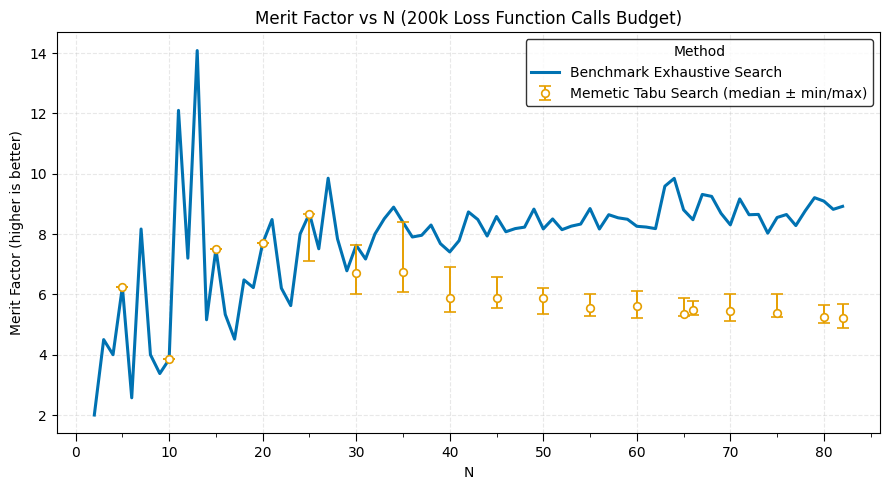

In [90]:
# plot graph with N as x axis, MF_Exhaustive and MF_MTS as hues.
# MF_Exhaustive is shown as a blue line. MF_MTS is shown as median points with min/max error bars (no connecting line).
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.style.use("default")

# More pleasant, colorblind-friendly palette (Okabe-Ito)
COLOR_EXHAUSTIVE = "#0072B2"  # blue
COLOR_MTS = "#E69F00"  # orange

# Aggregate duplicates (MTS has multiple runs per N); use median + min/max error bars
df_plot = (
    df_joined.groupby("N", as_index=False)
    .agg(
        MF_Exhaustive=("MF_Exhaustive", "max"),
        MF_MTS_median=("MF_MTS", "median"),
        MF_MTS_min=("MF_MTS", "min"),
        MF_MTS_max=("MF_MTS", "max"),
    )
    .sort_values("N")
    .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(9, 5), facecolor="white")
ax.set_facecolor("white")

# Exhaustive: connect with lines
exh = df_plot.dropna(subset=["MF_Exhaustive"])
ax.plot(
    exh["N"],
    exh["MF_Exhaustive"],
    color=COLOR_EXHAUSTIVE,
    linewidth=2.2,
    label="Benchmark Exhaustive Search",
)

# MTS: median with min/max error bars (no connecting line)
mts = df_plot.dropna(subset=["MF_MTS_median"])
yerr_lower = (mts["MF_MTS_median"] - mts["MF_MTS_min"]).to_numpy()
yerr_upper = (mts["MF_MTS_max"] - mts["MF_MTS_median"]).to_numpy()

ax.errorbar(
    mts["N"],
    mts["MF_MTS_median"],
    yerr=[yerr_lower, yerr_upper],
    fmt="o",
    linestyle="None",
    markersize=5.5,
    markerfacecolor="white",
    markeredgecolor=COLOR_MTS,
    markeredgewidth=1.2,
    ecolor=COLOR_MTS,
    elinewidth=1.4,
    capsize=4,
    label="Memetic Tabu Search (median ± min/max)",
)

ax.set_xlabel("N", color="black")
ax.set_ylabel("Merit Factor (higher is better)", color="black")
ax.set_title("Merit Factor vs N (200k Loss Function Calls Budget)", color="black")

# Major ticks every 10, small (minor) ticks every 5 on x-axis
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis="x", which="minor", length=3, colors="black")
ax.tick_params(axis="x", which="major", length=6, colors="black")

ax.tick_params(axis="both", colors="black")
for spine in ax.spines.values():
    spine.set_color("black")

ax.grid(True, linestyle="--", alpha=0.35, color="0.75")
ax.legend(facecolor="white", edgecolor="black", title="Method")
plt.tight_layout()
plt.show()
